In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

### 4.1 Monte-Carlo Sampling

$$ \int_{0}^{\pi} \frac{dx}{x^2 + \cos(x)^2}$$

In [2]:
def func(x):
    return 1/(np.power(x, 2) + np.power(np.cos(x), 2))

In [3]:
import scipy.integrate as integrate
import scipy.special as special
x = np.linspace(0, np.pi, 10000)
result = integrate.quad(func, 0, np.pi)
print(result)

(1.5811879708477277, 1.2372872371839774e-10)


approximated result: 1.5811879708477277

### a)

In [4]:
samples = np.random.uniform(0, np.pi, 100)
integral = np.mean([func(i) for i in samples])*np.pi

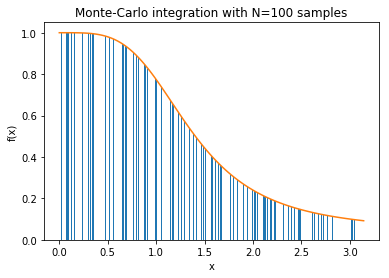

Estimated integral value: 1.6435782893991921


In [5]:
x = np.linspace(0, np.pi, 100)
plt.plot(x, func(x), c='C1')
plt.bar(samples, func(samples), width=0.01)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Monte-Carlo integration with N=100 samples')
plt.show()
print('Estimated integral value:',integral)

### b)

In [6]:
def mc_sampling(N, p):
    for i in range(len(N)):
        samples = np.random.uniform(0, np.pi, N[i])
        integral = np.mean([func(i) * p(i) for i in samples])*np.pi
        diff = [(func(i) - np.mean(func(samples))**2) for i in samples]
        variance = np.sum(diff)/(N[i]-1)
        plt.plot(samples, func(samples), '.')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('N={0}'.format(N[i]))
        plt.show()
        print('Estimated integral:', integral)
        print('Error:', np.abs(result[0]-integral)*100, '%')
        print('Variance: ', variance)

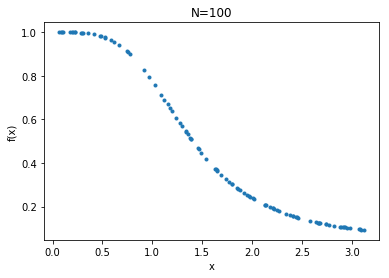

Estimated integral: 1.4626240626495566
Error: 11.856390819817108 %
Variance:  0.25132769357753687


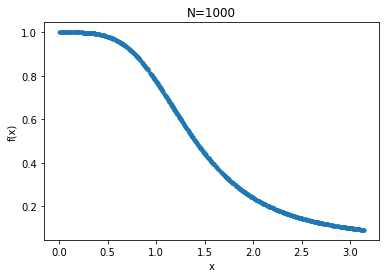

Estimated integral: 1.54849954122006
Error: 3.2688429627667714 %
Variance:  0.25019982834162674


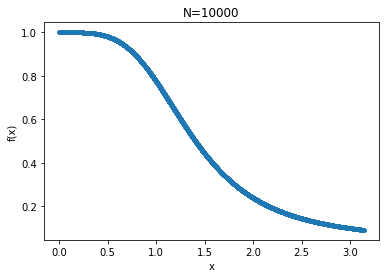

Estimated integral: 1.5816885423000258
Error: 0.05005714522980931 %
Variance:  0.2500129805164894


In [7]:
def p1(x):
    return 1
mc_sampling([100, 1000, 10000], p1)

### c)

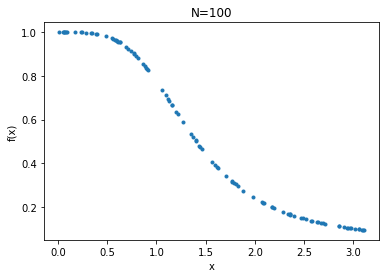

Estimated integral: 0.8316499907651277
Error: 74.95379800826 %
Variance:  0.2512884015259571


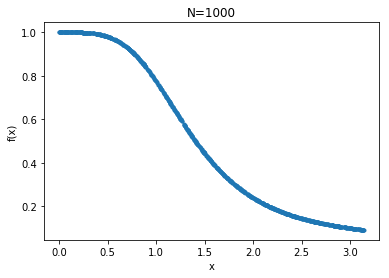

Estimated integral: 0.7575232410538335
Error: 82.36647297938941 %
Variance:  0.25019275011103476


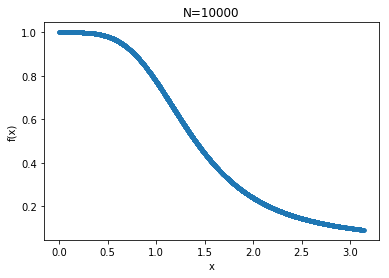

Estimated integral: 0.7442610002463494
Error: 83.69269706013782 %
Variance:  0.25001186988950935


In [8]:
def p2(x):
    return np.exp(-x)
mc_sampling([100, 1000, 10000], p2)

### 4.2 Markov Chain Monte-Carlo

In [9]:
class MCMC:
    def __init__(self, parameters, method='mc'):
        self.k = parameters['k']
        self.K = parameters['K']
        self.kbT = parameters['kbT']
        self.method = method
        self.pos, self.energy = None, None
    
    def __mc_step(self, pos, energy):
        pos_trial = pos +  np.random.uniform(-0.5, 0.5, *pos.shape)
        energy_trial = self.pot(pos_trial[0], pos_trial[1])
        if energy_trial <= energy or np.random.rand() < np.exp(-(energy_trial - energy)/self.kbT):
            return pos_trial, energy_trial
        return pos, energy
    
    def __hastings_step(self, pos, energy):
        pos_trial =  pos + np.random.uniform(-0.5, 0.5, *pos.shape)
        energy_trial = self.pot(pos_trial[0], pos_trial[1])

        if np.random.rand() < np.min([1, np.exp(-(energy_trial - energy)/self.kbT)]):
            return pos_trial, energy_trial
        return pos, energy

    def pot(self, x, y):
        part_1 = (-self.K*(np.power(x,2) + np.power(y,2)))/2
        part_2 = (self.k*np.power((np.abs(x-y)-0.5), 2))/2
        return part_1 + part_2 + 2
    
    def markov_chain(self, init_pos, N):
        pos = [init_pos, ]
        energy = [self.pot(init_pos[0], init_pos[1]), ]

        for i in range(N):
            if self.method=='mc':
                pos_, energy_ = self.__mc_step(pos[-1], energy[-1])
            elif self.method=='hastings':
                pos_, energy_ = self.__hastings_step(pos[-1], energy[-1])
            pos.append(pos_)
            energy.append(energy_)

        self.pos = np.asarray(pos)
        self.energy = np.asarray(energy)
        return self.pos, self.energy
    
    def plot(self):       
        fig, ax = plt.subplots(1,2, figsize=(10, 5))
        ax[0].plot(*self.pos[:100].T, '--', color='grey')
        ax[0].scatter(*self.pos[:100].T, c=self.energy[:100])
        ax[0].set_title('Random walk in first 100 step')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[1].hist2d(*self.pos.T,  bins=100)
        ax[1].set_title('2D histogram of positions')

In [10]:
def plot_3D_pot(k, K, pot):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Potential field k={} and K={}'.format(k, K))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')
    x = y = np.linspace(-1, 1, 101)
    X, Y = np.meshgrid(x, y)
    zs = np.array([pot(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)

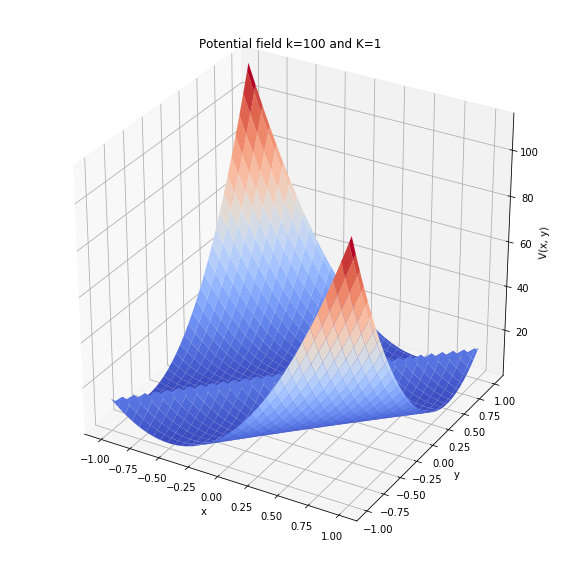

In [11]:
parameters1 = {
    'k': 100,
    'K': 1, #pN/nm
    'kbT': 4 #pN*nm
}
mc1 = MCMC(parameters1, method='mc')
plot_3D_pot(parameters1['k'], parameters1['K'], mc1.pot)

In [12]:
init_pos = np.random.uniform(-0.5, 0.5, 2)
print(init_pos)

[ 0.10106936 -0.15781416]


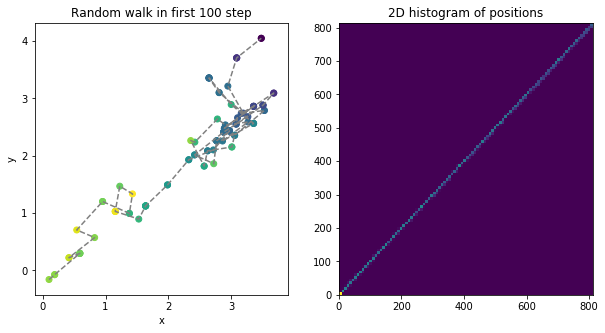

In [13]:
mc1_pos, mc1_energy = mc1.markov_chain(init_pos, 10000)
mc1.plot()

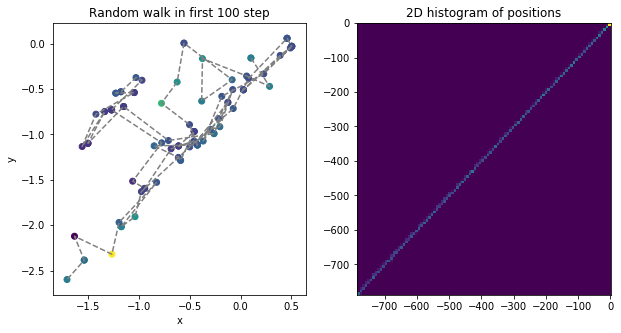

In [14]:
hastings1 = MCMC(parameters1, method='hastings')
hastings1_pos, hastings1_energy = hastings1.markov_chain(init_pos, 10000)
hastings1.plot()

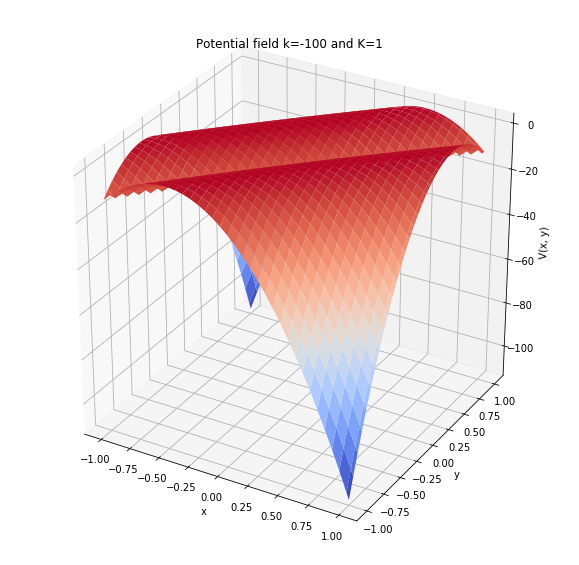

In [16]:
parameters2 = {
    'k': -100,
    'K': 1, #pN/nm
    'kbT': 4 #pN*nm
}

mc2 =  MCMC(parameters2)
plot_3D_pot(parameters2['k'], parameters2['K'], mc2.pot)

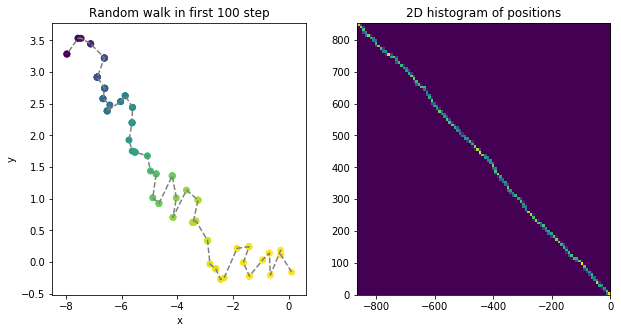

In [17]:
mc2_pos, mc2_energy = mc2.markov_chain(init_pos, 10000)
mc2.plot()

/Users/evabertalan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


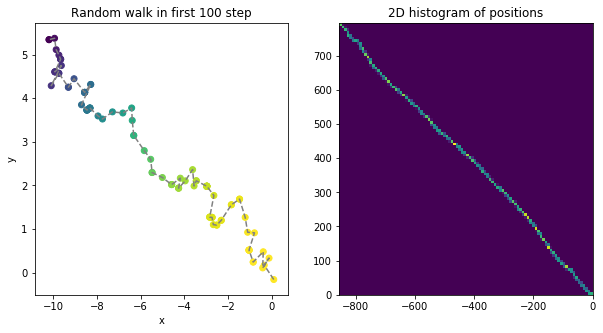

In [18]:
hastings2 = MCMC(parameters2, method='hastings')
hastings2_pos, hastings2_energy = hastings2.markov_chain(init_pos, 10000)
hastings2.plot()

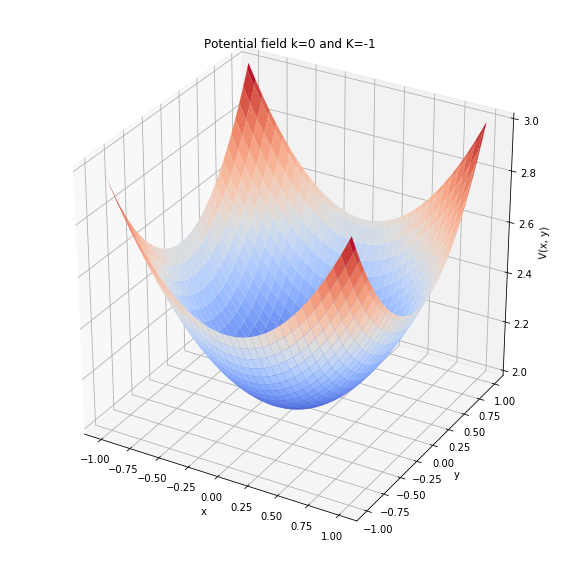

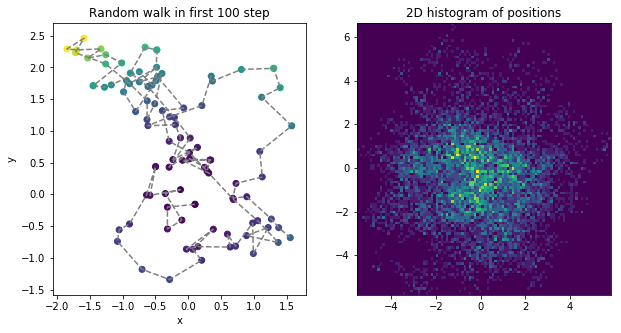

In [19]:
parameters3 = {
    'k': 0,
    'K': -1, #pN/nm
    'kbT': 4 #pN*nm
}
mc3 =  MCMC(parameters3)
plot_3D_pot(parameters3['k'], parameters3['K'], mc3.pot)

hastings3 = MCMC(parameters3, method='hastings')
hastings3_pos, hastings3_energy = hastings3.markov_chain(init_pos, 10000)
hastings3.plot()

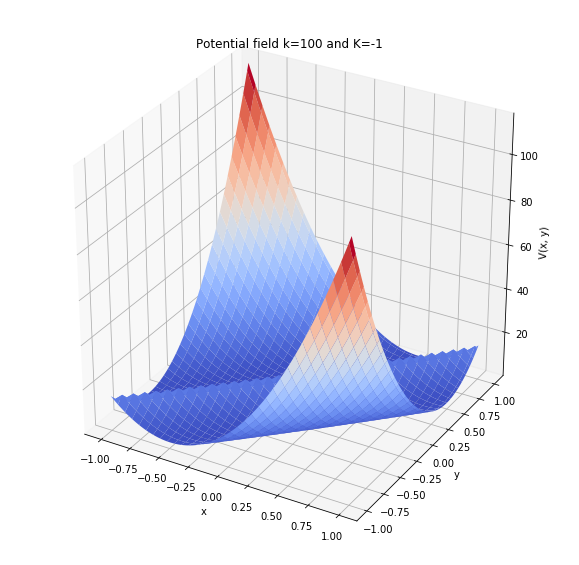

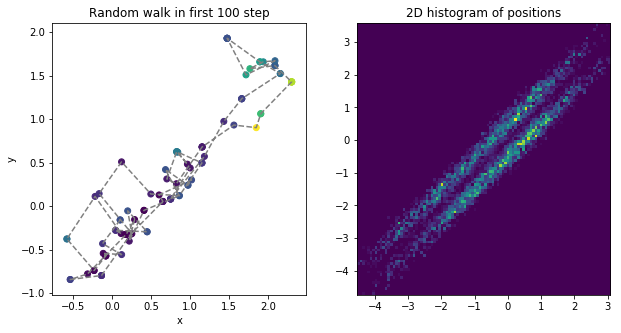

In [27]:
parameters4 = {
    'k': 100,
    'K': -1, #pN/nm
    'kbT': 4 #pN*nm
}
mc4 =  MCMC(parameters4)
plot_3D_pot(parameters4['k'], parameters4['K'], mc4.pot)

hastings4 = MCMC(parameters4, method='hastings')
hastings4_pos, hastings4_energy = hastings4.markov_chain(init_pos, 10000)
hastings4.plot()